<a href="https://colab.research.google.com/github/pawarharshit/tensorflow_programs/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

In [0]:
(training_data,testing_data),info = tfds.load('tf_flowers',with_info=True,split=['train[:80%]','train[80%:]'],as_supervised=True,)

In [4]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [12]:
print(info.features['image'].shape)
info.features['label']

(None, None, 3)


ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

In [0]:
no_of_classes = info.features['label'].num_classes

In [16]:
#checking the size of images
for i,example in enumerate(training_data.take(5)):
    print(f'image:{i+1} shape{example[0].shape} label:{example[1]}')

image:1 shape(333, 500, 3) label:2
image:2 shape(212, 320, 3) label:3
image:3 shape(240, 320, 3) label:3
image:4 shape(240, 320, 3) label:4
image:5 shape(317, 500, 3) label:3


In [0]:
# so all images are different size we have to resize all 
IMG_SIZE = 224

def resize_img(image,label):
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))/255.0
    return image,label

In [0]:
num_training_examples = 0
num_testing_examples = 0

for example in training_data:
  num_training_examples += 1

for example in testing_data:
  num_validation_examples += 1

In [0]:
BATCH_SIZE = 32

training_batch = training_data.shuffle(num_training_examples//4).map(resize_img).batch(BATCH_SIZE).prefetch(1)
testing_batch = testing_data.map(resize_img).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [0]:
#now we have to freeze this model
feature_extractor.trainable = False

In [39]:
#now we use this pretrained neural network in our model
from tensorflow.keras import layers
model = tf.keras.Sequential([
                feature_extractor,
                layers.Dense(no_of_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [42]:
history = model.fit(training_batch,epochs=5,validation_data=testing_batch)

Epoch 1/5
92/92 [==============================] - 10s 111ms/step - loss: 0.7788 - accuracy: 0.7176 - val_loss: 0.4325 - val_accuracy: 0.8624
Epoch 2/5
92/92 [==============================] - 9s 97ms/step - loss: 0.3874 - accuracy: 0.8696 - val_loss: 0.3386 - val_accuracy: 0.8869
Epoch 3/5
92/92 [==============================] - 9s 97ms/step - loss: 0.3025 - accuracy: 0.8992 - val_loss: 0.2987 - val_accuracy: 0.8965
Epoch 4/5
92/92 [==============================] - 9s 97ms/step - loss: 0.2554 - accuracy: 0.9227 - val_loss: 0.2836 - val_accuracy: 0.8992
Epoch 5/5
92/92 [==============================] - 9s 97ms/step - loss: 0.2160 - accuracy: 0.9390 - val_loss: 0.2814 - val_accuracy: 0.9074


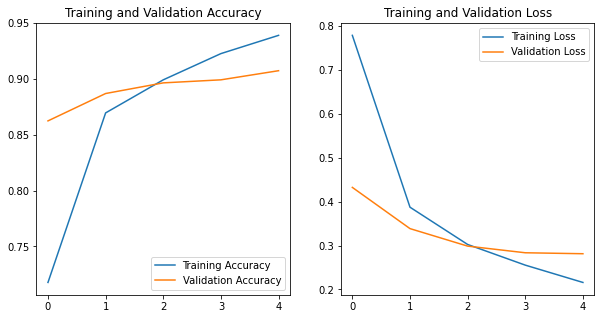

In [45]:
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(5)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
#now check some predictions
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [0]:
image_batch,label_batch = next(iter(training_batch))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)

In [0]:
predicted_labels_no = []
for pred in predicted_batch:
    predicted_labels_no.append(np.argmax(pred))

In [59]:
predicted_labels_no = np.array(predicted_labels_no)
predicted_labels_no.shape

(32,)

In [0]:
predicted_class_names = class_names[predicted_labels_no]

In [61]:
predicted_class_names

array(['daisy', 'sunflowers', 'sunflowers', 'daisy', 'roses', 'tulips',
       'dandelion', 'daisy', 'daisy', 'roses', 'tulips', 'tulips',
       'roses', 'sunflowers', 'dandelion', 'tulips', 'dandelion',
       'sunflowers', 'dandelion', 'daisy', 'dandelion', 'dandelion',
       'tulips', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers',
       'sunflowers', 'roses', 'sunflowers', 'dandelion', 'sunflowers'],
      dtype='<U10')

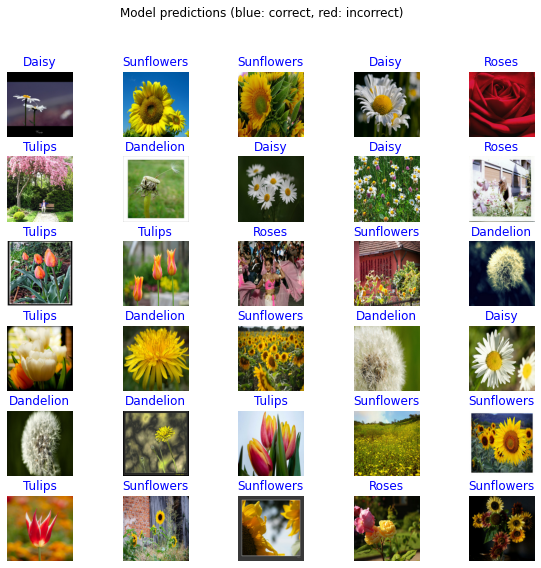

In [62]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_labels_no[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")